In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os
from scipy import stats
import mne
from scipy.signal import butter, filtfilt
from moduloproyecto import *
import re
from networkx.algorithms import community

La cirugía asistida por robot (RAS), es una nueva aplicación en la medicina en donde el cirujano controla un sistema quirúrgico robótico como si fueran sus propias manos, lo que les permite ser más precisos, controlados y flexibles los movimientos, además de tener un mayor campo de visión (Mayo Clinic, s.f.). La finalidad de esta herramienta es minimizar la invasividad quirúrgica al permitir incisiones más pequeñas, reducir el dolor y la pérdida de sangre y por lo tanto, lleva a una recuperación más rápida (Muacevic, A & Alder, J., 2025). 
Sin embargo, a pesar de su implementación en la clínica es escasa la literatura que documenta similitudes o diferencias cerebrales entre usar esta técnica y los métodos convencionales. Además las evaluaciones de esta técnica son subjetivas porque dependen en gran medida de las opiniones del evaluador. Por lo cual evaluar su desempeño desde otras métricas como la cinemática de la mano, electroencefalograma y mirada ocular pueden proporcionar información sobre el rendimiento de SAR (Shafiei, S,, et al, 2023), como por ejemplo, la atención, coordinación motora, aprendizaje, y evaluación de fatiga que podría ser interesante comparar entre cirujanos novatos y expertos, o cómo cambia la actividad cerebral dependiendo de las tareas y su dificultad.
Datos de https://physionet.org/content/eeg-eye-gaze-data/1.0.0/#files-panel

Los datos se obtuvieron de la plataforma Physionet. Los datos se encontraban en crudo, por lo que el primer paso fue preprocesarlos (el preprocesado se encuentra en dos notebook diferentes), debido a que mi computadora no soporta tantas cosas, lo que hice para reducir los datos y que además fuera parte de mi análisis, tome la tarea 1, 4, 9, 15, 17, 23 que corresponden a la primera tarea de cada apartado de la tabla 1. A estos datos les aplique un filtro de 5 - 40 Hz, el artículo reportó que para algunos sujetos los canales podían estar ruidosos, así que modifique el código para que leyera estos canales y si los encontraba defectuosos los eliminará. Aplique la Phase Locking Value (PLV) para medir sincronía de fase entre pares de canales, use este método ya que la literatura reporta que es una de las medidas de interacción de fase más utilizada para electroencefalograma, consiste en medir qué tan constante son las diferencias de fase entre dos señales, en este caso entre dos electrodos, en el cual si la diferencia es siempre parecida PLV ≈ 1, y si la diferencia de fase cambia mucho al azar PLV ≈ 0. (Aydore, S., Pantazis, D & Leahy, R, 2013). Estos datos los convertí a xlsx y los guardé en otra carpeta para su posterior análisis. El reajuste del tamaño de las matrices por los electrodos eliminados (de 128x128 a 124x124), el cambio de nombre de los electrodos para mejor visualización y la eliminación de la diagonal se hizo en el notebook del proyecto.


In [3]:
datos = r"C:\Users\HP\Documents\PLV_matrices_completas"

In [4]:
plv_dict = {}

pattern = re.compile(r"Tarea_(\d+)_Sujeto_(\d+)_PLV\.xlsx")

for file in os.listdir(datos):
    match = pattern.match(file)
    if match:
        tarea = match.group(1)
        sujeto = match.group(2)

        df = pd.read_excel(os.path.join(datos, file), index_col=0)

        if tarea not in plv_dict:
            plv_dict[tarea] = {}

        plv_dict[tarea][sujeto] = df

        print(f"Cargado: Tarea {tarea} – Sujeto {sujeto}")

    else:
        print("Archivo ignorado (no coincide con patrón):", file)

print("\nTareas encontradas:", list(plv_dict.keys()))

Cargado: Tarea 15 – Sujeto 10
Cargado: Tarea 15 – Sujeto 11
Cargado: Tarea 15 – Sujeto 12
Cargado: Tarea 15 – Sujeto 13
Cargado: Tarea 15 – Sujeto 14
Cargado: Tarea 15 – Sujeto 15
Cargado: Tarea 15 – Sujeto 16
Cargado: Tarea 15 – Sujeto 19
Cargado: Tarea 15 – Sujeto 1
Cargado: Tarea 15 – Sujeto 20
Cargado: Tarea 15 – Sujeto 21
Cargado: Tarea 15 – Sujeto 22
Cargado: Tarea 15 – Sujeto 23
Cargado: Tarea 15 – Sujeto 24
Cargado: Tarea 17 – Sujeto 10
Cargado: Tarea 17 – Sujeto 11
Cargado: Tarea 17 – Sujeto 12
Cargado: Tarea 17 – Sujeto 13
Cargado: Tarea 17 – Sujeto 14
Cargado: Tarea 17 – Sujeto 15
Cargado: Tarea 17 – Sujeto 16
Cargado: Tarea 17 – Sujeto 17
Cargado: Tarea 17 – Sujeto 19
Cargado: Tarea 17 – Sujeto 1
Cargado: Tarea 17 – Sujeto 20
Cargado: Tarea 17 – Sujeto 21
Cargado: Tarea 17 – Sujeto 22
Cargado: Tarea 17 – Sujeto 23
Cargado: Tarea 17 – Sujeto 24
Cargado: Tarea 1 – Sujeto 10
Cargado: Tarea 1 – Sujeto 11
Cargado: Tarea 1 – Sujeto 12
Cargado: Tarea 1 – Sujeto 13
Cargado: Tarea 1

# Tarea 1 - Manipulación de EndoWrist

In [5]:
lista = lista_dfs(plv_dict["1"])
for i in range(len(lista)):
    np.fill_diagonal(lista[i].values, np.nan)
    
lista_recor, comunes = recortar_a_comunes(lista)
lista_recortada = [limpiar_nombres_canales(df.copy()) for df in lista_recor]

In [22]:
capsula_t1 = capsula(lista_recortada, 0.4, 0.7)
capsula_t1 = limpiar_nombres_canales(capsula_t1)
capsula_t1

AF3  AF4  AF7  AF8  AFF1  AFF2  AFF5h  AFF6h  AFp3h  AFp4h  ...  T7  \
AF3      0    0    1    0     1     1      1      0      0      0  ...   0   
AF4      0    0    0    1     0     0      0      1      0      0  ...   0   
AF7      1    0    0    0     1     0      1      0      1      0  ...   0   
AF8      0    1    0    0     0     0      0      1      0      0  ...   0   
AFF1     1    0    1    0     0     1      1      0      0      0  ...   0   
...    ...  ...  ...  ...   ...   ...    ...    ...    ...    ...  ...  ..   
TPP7h    0    0    0    0     0     0      0      0      0      0  ...   0   
TPP8h    0    0    0    0     0     0      0      0      0      0  ...   0   
TPP9h    0    0    0    0     0     0      0      0      0      0  ...   0   
TTP7h    0    0    0    0     0     0      0      0      0      0  ...   1   
TTP8h    0    0    0    0     0     0      0      0      0      0  ...   0   

       T8  TP7  TP8  TPP10h  TPP7h  TPP8h  TPP9h  TTP7h  TTP8h  
AF3     0    0    0       0      0      0      0      0      0  
AF4     0    0    0       0      0      0      0      0      0  
AF7     0    0    0       0      0      0      0      0      0  
AF8     0    0    0       0      0      0      0      0      0  
AFF1    0    0    0       0      0      0      0      0      0  
...    ..  ...  ...     ...    ...    ...    ...    ...    ...  
TPP7h   0    0    0       0      0      0      1      0      0  
TPP8h   0    0    0       1      0      0      0      0      0  
TPP9h   0    0    0       0      1      0      0      0      0  
TTP7h   0    0    0       0      0      0      0      0      0  
TTP8h   1    0    1       0      0      0      0      0      0  

[124 rows x 124 columns]

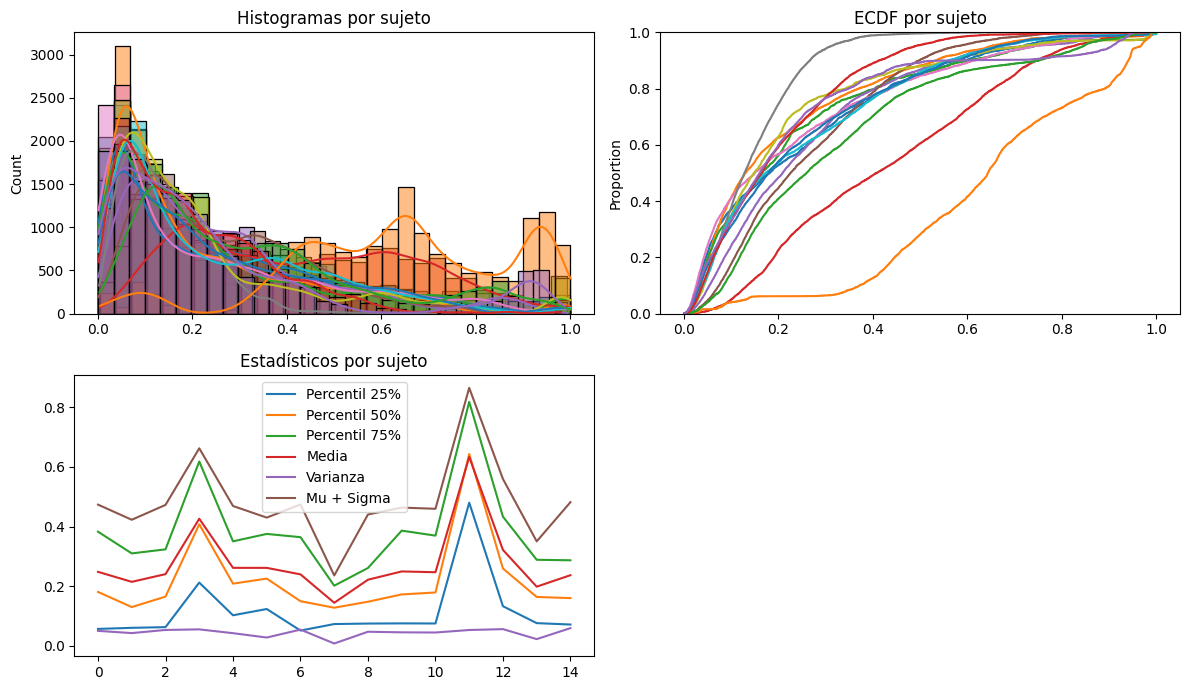

th25      th50      th75  promedio  mu_sigma
min      0.051728  0.128287  0.202159  0.144852   0.23645
max      0.480422  0.643536  0.818313  0.633585  0.865139
mediana  0.075464  0.172902  0.364731  0.247272  0.469215
MAD      0.014557  0.024554  0.054378   0.01465  0.028431

In [23]:
tarea1 = lista_dfs((plv_dict["1"]))

tabla = analisis_estadisticos(tarea1)
tabla

Text(0.5, 0.98, 'Análisis para valor de umbral al 70 de la población en la tarea 1')

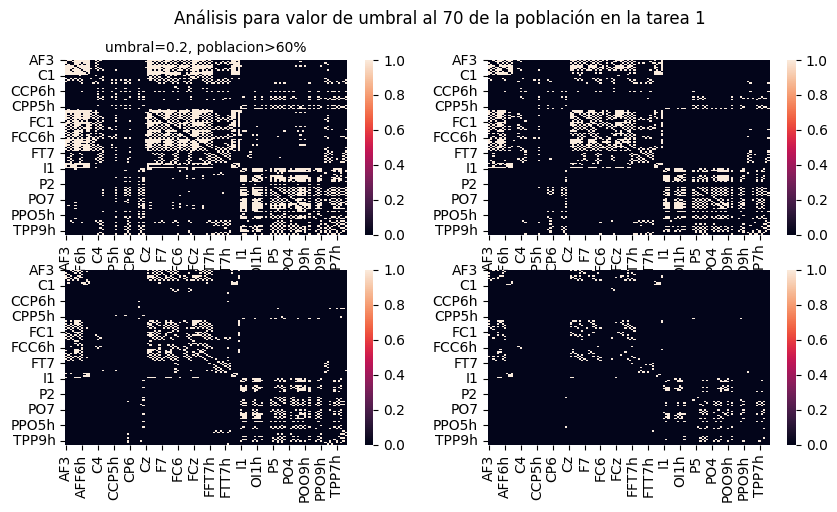

In [31]:
# Análisis para valor de umbral al 60% de la población en la tarea 1
tarea1u1 = capsula(lista_recortada, 0.3, 0.6)
tarea1u2 = capsula(lista_recortada, 0.4, 0.6) # umbral elegido basandome en el mapa de calor ya que conserva conexiones 
# fuertes entre regiones, ademas de considerar el percentil 50
tarea1u3 = capsula(lista_recortada, 0.5, 0.6)
tarea1u4 = capsula(lista_recortada, 0.6, 0.6)

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

sns.heatmap(tarea1u1, ax=axes[0, 0])
sns.heatmap(tarea1u2, ax=axes[0, 1])
sns.heatmap(tarea1u3, ax=axes[1, 0])
sns.heatmap(tarea1u4, ax=axes[1, 1])

# plt.title('Mapas de calor para comparativa de umbrales')
axes[0, 0].set_title('umbral=0.2, poblacion>60%', fontsize=10)
fig.suptitle('Análisis para valor de umbral al 70 de la población en la tarea 1')

In [38]:
G = nx.from_pandas_adjacency(capsula_t1)

result = metricas_grafo_resumido(G)

hub_principal = result["top5_hubs"][0]

comunidades = community.greedy_modularity_communities(G)

In [39]:
result

{'clustering': 0.47911330342981695,
 'path_length': nan,
 'small_world_sigma': nan,
 'modularidad': 0.5620850684116597,
 'eficiencia_global': 0.1746599864715529,
 'eficiencia_local': 0.569585825611742,
 'top5_hubs': [('TTP8h', 0.1728138759449554),
  ('PO10', 0.1598712373828894),
  ('FTT8h', 0.1549365605891719),
  ('FC6', 0.1386766062972347),
  ('FFT8h', 0.1270379251139083)],
 'comunidades': [frozenset({'AF3',
             'AF4',
             'AF8',
             'AFF1',
             'AFF2',
             'AFF5h',
             'AFF6h',
             'C4',
             'C6',
             'CCP6h',
             'F1',
             'F2',
             'F3',
             'F4',
             'F5',
             'F6',
             'F8',
             'FC1',
             'FC2',
             'FC3',
             'FC4',
             'FC6',
             'FCC4h',
             'FCC6h',
             'FCz',
             'FFC1h',
             'FFC2h',
             'FFC4h',
             'FFC5h',
             'FF

In [12]:
coords = generar_coords_esfera_para_canales(capsula_t1.index)
coords

x         y         z
AF3    0.000000  1.000000  0.000000
AF4   -0.132431  0.983740  0.121318
AF7    0.022114  0.967480 -0.251980
AF8    0.187712  0.951220  0.244838
AFF1  -0.349332  0.934959 -0.061792
...         ...       ...       ...
TPP7h -0.340012 -0.934959  0.101207
TPP8h  0.158582 -0.951220 -0.264638
TPP9h  0.050692 -0.967480  0.247817
TTP7h -0.145396 -0.983740 -0.105432
TTP8h  0.000000 -1.000000 -0.000000

[124 rows x 3 columns]

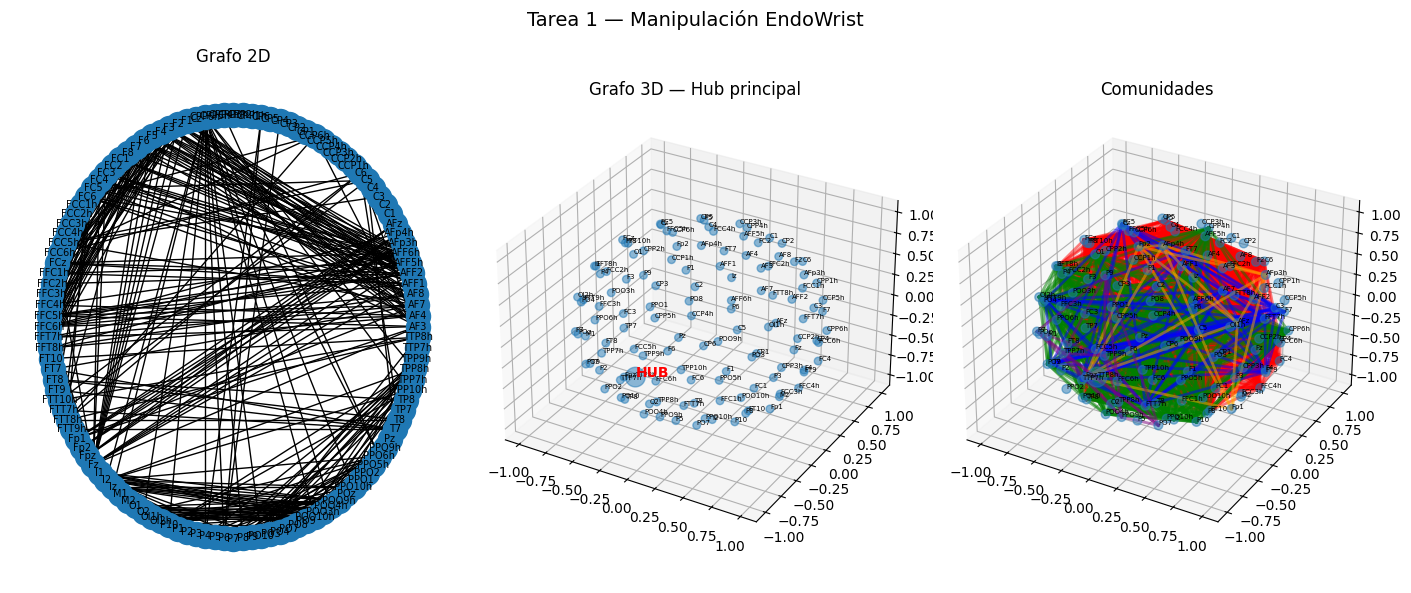

In [73]:
fig = plt.figure(figsize=(14, 6))

fig.suptitle("Tarea 1 — Manipulación EndoWrist", fontsize=14)

# grafo 2d
ax1 = fig.add_subplot(1, 3, 1)
grafo2D(capsula_t1, ax1)
ax1.set_title("Grafo 2D")

# grafo 3d
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
grafo3D(coords, hub_principal, ax2)
ax2.set_title("Grafo 3D — Hub principal")

# grafo comunidades
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
grafo_comunidades(comunidades, hub_principal, coords, ax3)

plt.tight_layout()
plt.show()

In [33]:
hub_principal

('TTP8h', 0.1728138759449554)

# Tarea 2 Manipulación de EdnoWrits 2

In [15]:
lista2 = lista_dfs(plv_dict["4"])
for i in range(len(lista)):
    np.fill_diagonal(lista2[i].values, np.nan)
    
lista_recor2, comunes = recortar_a_comunes(lista2)
lista_recortada2 = [limpiar_nombres_canales(df.copy()) for df in lista_recor2]

In [49]:
capsula_t2 = capsula(lista_recortada2, 0.4, 0.7)
capsula_t2 = limpiar_nombres_canales(capsula_t2)
capsula_t2

AF3  AF4  AF7  AF8  AFF1  AFF2  AFF5h  AFF6h  AFp3h  AFp4h  ...  T7  \
AF3      0    0    1    0     1     1      1      0      0      1  ...   0   
AF4      0    0    0    1     1     1      0      1      0      1  ...   0   
AF7      1    0    0    0     1     0      1      0      0      0  ...   0   
AF8      0    1    0    0     0     1      0      1      0      1  ...   0   
AFF1     1    1    1    0     0     1      1      1      0      0  ...   0   
...    ...  ...  ...  ...   ...   ...    ...    ...    ...    ...  ...  ..   
TPP7h    0    0    0    0     0     0      0      0      0      0  ...   0   
TPP8h    0    0    0    0     0     0      0      0      0      0  ...   0   
TPP9h    0    0    0    0     0     0      0      0      0      0  ...   0   
TTP7h    0    0    0    0     0     0      0      0      0      0  ...   0   
TTP8h    0    0    0    0     0     0      0      0      0      0  ...   0   

       T8  TP7  TP8  TPP10h  TPP7h  TPP8h  TPP9h  TTP7h  TTP8h  
AF3     0    0    0       0      0      0      0      0      0  
AF4     0    0    0       0      0      0      0      0      0  
AF7     0    0    0       0      0      0      0      0      0  
AF8     0    0    0       0      0      0      0      0      0  
AFF1    0    0    0       0      0      0      0      0      0  
...    ..  ...  ...     ...    ...    ...    ...    ...    ...  
TPP7h   0    0    0       0      0      0      1      1      0  
TPP8h   0    0    0       1      0      0      0      0      0  
TPP9h   0    0    0       0      1      0      0      0      0  
TTP7h   0    0    0       0      1      0      0      0      0  
TTP8h   1    0    1       0      0      0      0      0      0  

[124 rows x 124 columns]

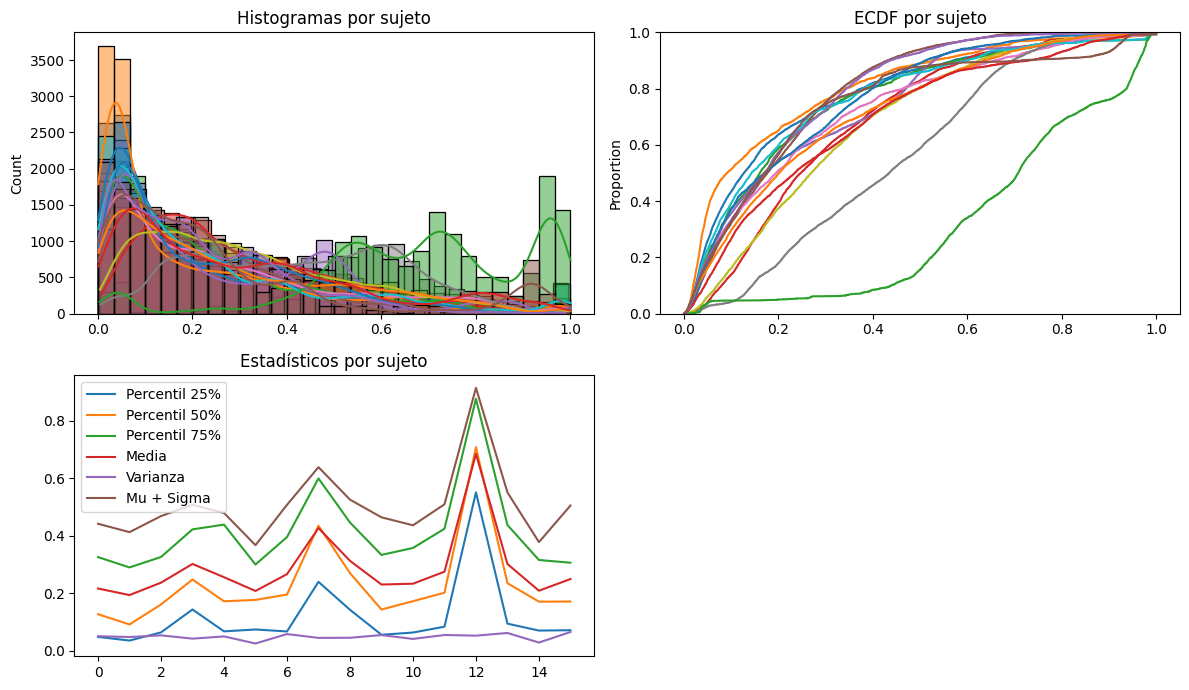

th25      th50      th75  promedio  mu_sigma
min      0.035504  0.091469  0.289591  0.193577  0.366817
max      0.550268  0.707485   0.87548   0.68443  0.913597
mediana  0.070786  0.174483  0.376194  0.252465  0.491738
MAD      0.014034  0.029228  0.060796  0.039941  0.041928

In [50]:
tarea2 = lista_dfs(plv_dict["4"])

tabla2 = analisis_estadisticos(tarea2)
tabla2

Text(0.5, 0.98, 'Análisis para valor de umbral al 60% de la población en la tarea 3')

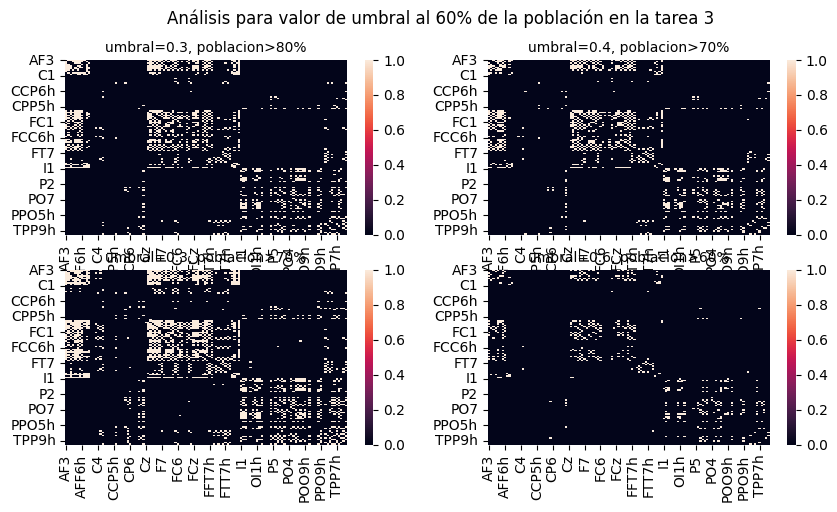

In [55]:
# Análisis para valor de umbral al 60% de la población en la tarea 3
tarea2u1 = capsula(lista_recortada2, 0.3, 0.8)
tarea2u2 = capsula(lista_recortada2, 0.4, 0.7) # umbral elegido se destacan redes sublocales 
tarea2u3 = capsula(lista_recortada2, 0.3, 0.7)
tarea2u4 = capsula(lista_recortada2, 0.6, 0.6)

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

sns.heatmap(tarea2u1, ax=axes[0, 0])
sns.heatmap(tarea2u2, ax=axes[0, 1])
sns.heatmap(tarea2u3, ax=axes[1, 0])
sns.heatmap(tarea2u4, ax=axes[1, 1])

# plt.title('Mapas de calor para comparativa de umbrales')
axes[0, 0].set_title('umbral=0.3, poblacion>80%', fontsize=10)
axes[0, 1].set_title('umbral=0.4, poblacion>70%', fontsize=10)
axes[1, 0].set_title('umbral=0.3, poblacion>70%', fontsize=10)
axes[1, 1].set_title('umbral=0.6, poblacion>60%', fontsize=10)
fig.suptitle('Análisis para valor de umbral al 60% de la población en la tarea 3')

In [57]:
G2 = nx.from_pandas_adjacency(capsula_t2)
result2 = metricas_grafo_resumido(G2)
hub_principal2 = result2["top5_hubs"][0]
comunidades2 = community.greedy_modularity_communities(G2)
result2

{'clustering': 0.5151853460488657,
 'path_length': nan,
 'small_world_sigma': nan,
 'modularidad': 0.5372133875739645,
 'eficiencia_global': 0.20989956040112703,
 'eficiencia_local': 0.6071217085309476,
 'top5_hubs': [('CCP6h', 0.16100371607775488),
  ('CPP6h', 0.1523876517403596),
  ('FCC6h', 0.12473488690788165),
  ('FTT7h', 0.10673638424167031),
  ('TTP7h', 0.1030694211653594)],
 'comunidades': [frozenset({'CP4',
             'CP5',
             'CP6',
             'CPP4h',
             'CPP6h',
             'I1',
             'I2',
             'Iz',
             'O1',
             'O2',
             'OI1h',
             'OI2h',
             'P10',
             'P4',
             'P6',
             'P7',
             'P8',
             'P9',
             'PO10',
             'PO7',
             'PO8',
             'PO9',
             'POO10h',
             'POO3h',
             'POO4h',
             'POO9h',
             'PPO10h',
             'PPO6h',
             'PPO9h',
       

In [53]:
coords2 = generar_coords_esfera_para_canales(capsula_t1.index)
coords2

x         y         z
AF3    0.000000  1.000000  0.000000
AF4   -0.132431  0.983740  0.121318
AF7    0.022114  0.967480 -0.251980
AF8    0.187712  0.951220  0.244838
AFF1  -0.349332  0.934959 -0.061792
...         ...       ...       ...
TPP7h -0.340012 -0.934959  0.101207
TPP8h  0.158582 -0.951220 -0.264638
TPP9h  0.050692 -0.967480  0.247817
TTP7h -0.145396 -0.983740 -0.105432
TTP8h  0.000000 -1.000000 -0.000000

[124 rows x 3 columns]

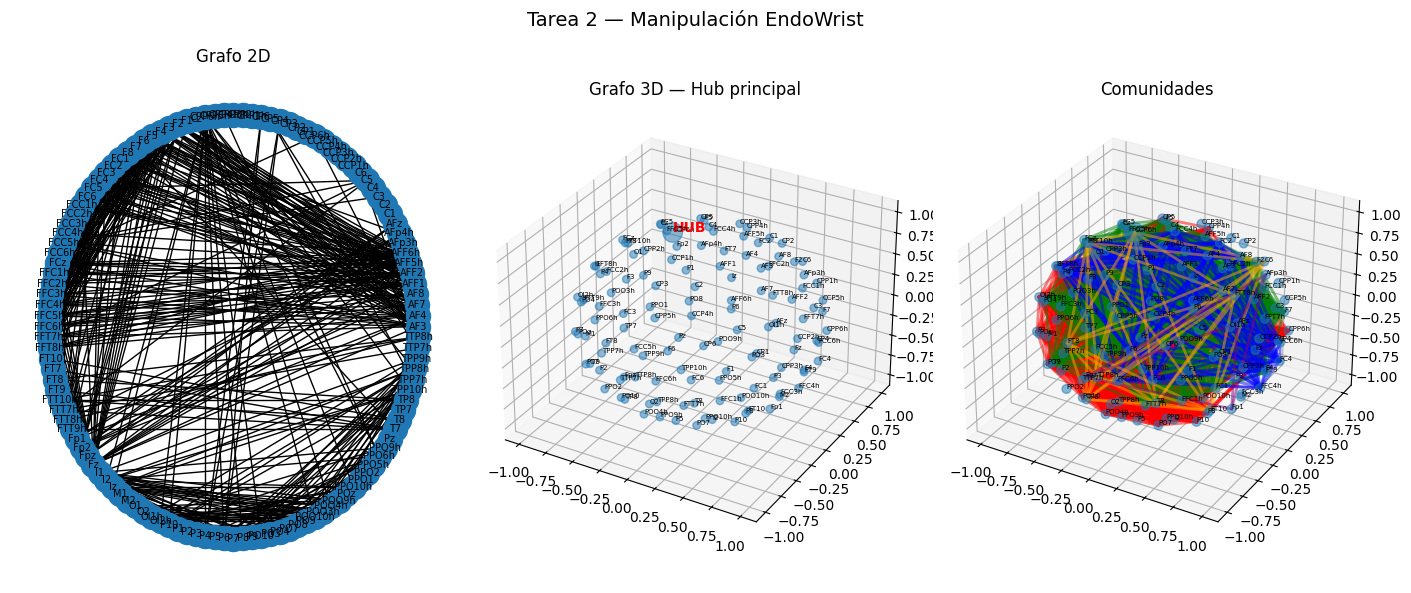

In [74]:
fig = plt.figure(figsize=(14, 6))

fig.suptitle("Tarea 2 — Manipulación EndoWrist", fontsize=14)

# grafo 2d
ax1 = fig.add_subplot(1, 3, 1)
grafo2D(capsula_t2, ax1)
ax1.set_title("Grafo 2D")

# grafo 3d
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
grafo3D(coords2, hub_principal2, ax2)
ax2.set_title("Grafo 3D — Hub principal")

# grafo comunidades
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
grafo_comunidades(comunidades2, hub_principal2, coords2, ax3)

plt.tight_layout()
plt.show()

# Tarea 3 Cámara y embrague

In [59]:
lista3 = lista_dfs(plv_dict["9"])
for i in range(len(lista3)):
    np.fill_diagonal(lista3[i].values, np.nan)
    
lista_recor3, comunes = recortar_a_comunes(lista3)
lista_recortada3 = [limpiar_nombres_canales(df.copy()) for df in lista_recor3]

In [63]:
capsula_t3 = capsula(lista_recortada3, 0.3, 0.7)
capsula_t3 = limpiar_nombres_canales(capsula_t3)
capsula_t3

AF3  AF4  AF7  AF8  AFF1  AFF2  AFF5h  AFF6h  AFp3h  AFp4h  ...  T7  \
AF3      0    1    1    1     1     1      1      1      1      1  ...   0   
AF4      1    0    1    1     1     1      1      1      0      1  ...   0   
AF7      1    1    0    0     1     1      1      0      0      0  ...   0   
AF8      1    1    0    0     1     1      1      1      0      1  ...   0   
AFF1     1    1    1    1     0     1      1      1      1      1  ...   0   
...    ...  ...  ...  ...   ...   ...    ...    ...    ...    ...  ...  ..   
TPP7h    0    0    0    0     0     0      0      0      0      0  ...   0   
TPP8h    0    0    0    0     0     0      0      0      0      0  ...   0   
TPP9h    0    0    0    0     0     0      0      0      0      0  ...   1   
TTP7h    0    0    0    0     0     0      0      0      0      0  ...   1   
TTP8h    0    0    0    0     0     0      0      0      0      0  ...   0   

       T8  TP7  TP8  TPP10h  TPP7h  TPP8h  TPP9h  TTP7h  TTP8h  
AF3     0    0    0       0      0      0      0      0      0  
AF4     0    0    0       0      0      0      0      0      0  
AF7     0    0    0       0      0      0      0      0      0  
AF8     0    0    0       0      0      0      0      0      0  
AFF1    0    0    0       0      0      0      0      0      0  
...    ..  ...  ...     ...    ...    ...    ...    ...    ...  
TPP7h   0    1    0       0      0      0      1      1      0  
TPP8h   1    0    1       1      0      0      0      0      1  
TPP9h   0    1    0       0      1      0      0      1      0  
TTP7h   0    1    0       0      1      0      1      0      0  
TTP8h   1    0    1       1      0      1      0      0      0  

[124 rows x 124 columns]

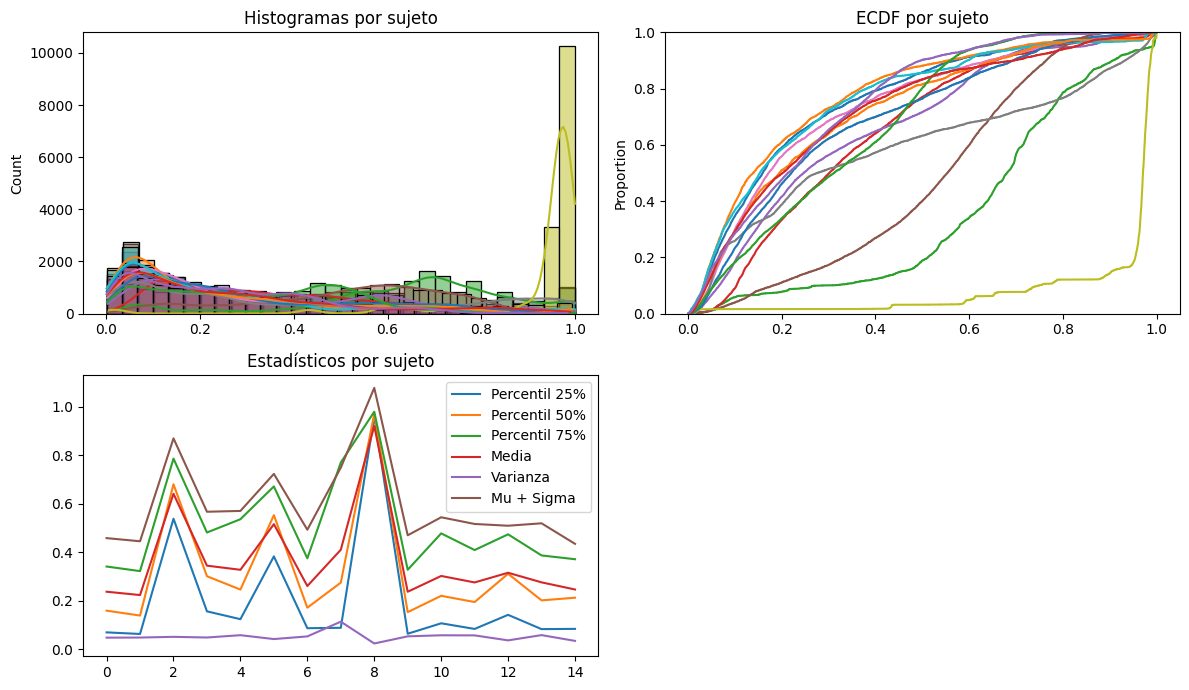

th25      th50      th75  promedio  mu_sigma
min      0.063903  0.139767  0.322927  0.224255  0.435351
max       0.96041  0.970965  0.979879   0.92118  1.078178
mediana   0.08929  0.221101  0.474606  0.303018  0.519977
MAD      0.024462  0.061116  0.102641  0.055815  0.051037

In [61]:
tarea3 = lista_dfs(plv_dict["9"])

tabla3 = analisis_estadisticos(tarea3)
tabla3

Text(0.5, 0.98, 'Análisis para valor de umbral al 60% de la población en la tarea 3')

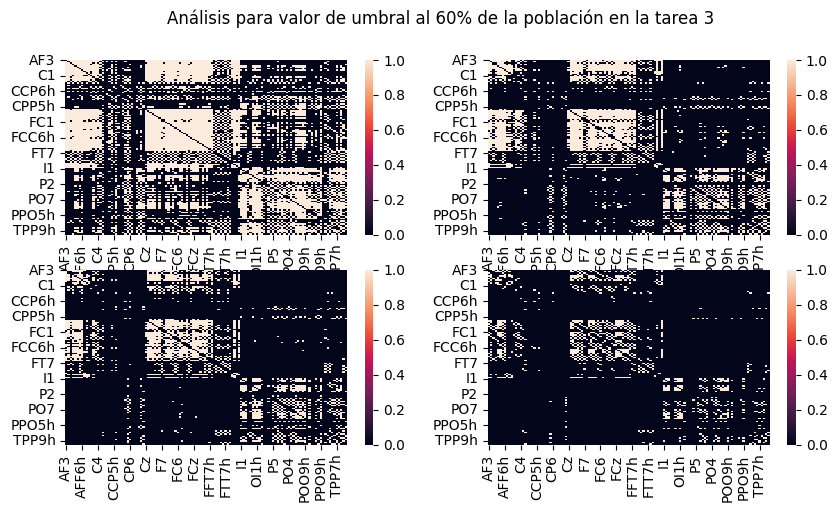

In [70]:
# Análisis para valor de umbral al 60% de la población en la tarea 3
tarea3u1 = capsula(lista_recortada3, 0.3, 0.5)
tarea3u2 = capsula(lista_recortada3, 0.3, 0.7)
tarea3u3 = capsula(lista_recortada3, 0.3, 0.8) #umbral elegido
tarea3u4 = capsula(lista_recortada3, 0.6, 0.6)

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

sns.heatmap(tarea3u1, ax=axes[0, 0])
sns.heatmap(tarea3u2, ax=axes[0, 1])
sns.heatmap(tarea3u3, ax=axes[1, 0])
sns.heatmap(tarea3u4, ax=axes[1, 1])

# plt.title('Mapas de calor para comparativa de umbrales')
fig.suptitle('Análisis para valor de umbral al 60% de la población en la tarea 3')

In [72]:
G3 = nx.from_pandas_adjacency(capsula_t3)
result3 = metricas_grafo_resumido(G3)
hub_principal3 = result3["top5_hubs"][0]
comunidades3 = community.greedy_modularity_communities(G3)
result3

{'clustering': 0.6477225523396819,
 'path_length': nan,
 'small_world_sigma': nan,
 'modularidad': 0.37931881735633266,
 'eficiencia_global': 0.4569761342774432,
 'eficiencia_local': 0.7650936381364747,
 'top5_hubs': [('FCC2h', 0.050661733973176346),
  ('O2', 0.03700092721687578),
  ('FFC6h', 0.032401458731318236),
  ('OI1h', 0.030041788885968954),
  ('FC4', 0.029809685033236985)],
 'comunidades': [frozenset({'AF3',
             'AF4',
             'AF7',
             'AF8',
             'AFF1',
             'AFF2',
             'AFF5h',
             'AFF6h',
             'AFp3h',
             'AFp4h',
             'AFz',
             'C1',
             'C2',
             'C3',
             'C4',
             'C5',
             'CCP3h',
             'CCP4h',
             'Cz',
             'F1',
             'F2',
             'F3',
             'F4',
             'F5',
             'F6',
             'F7',
             'F8',
             'FC1',
             'FC2',
             'FC3',


In [66]:
coords3 = generar_coords_esfera_para_canales(capsula_t3.index)
coords3

x         y         z
AF3    0.000000  1.000000  0.000000
AF4   -0.132431  0.983740  0.121318
AF7    0.022114  0.967480 -0.251980
AF8    0.187712  0.951220  0.244838
AFF1  -0.349332  0.934959 -0.061792
...         ...       ...       ...
TPP7h -0.340012 -0.934959  0.101207
TPP8h  0.158582 -0.951220 -0.264638
TPP9h  0.050692 -0.967480  0.247817
TTP7h -0.145396 -0.983740 -0.105432
TTP8h  0.000000 -1.000000 -0.000000

[124 rows x 3 columns]

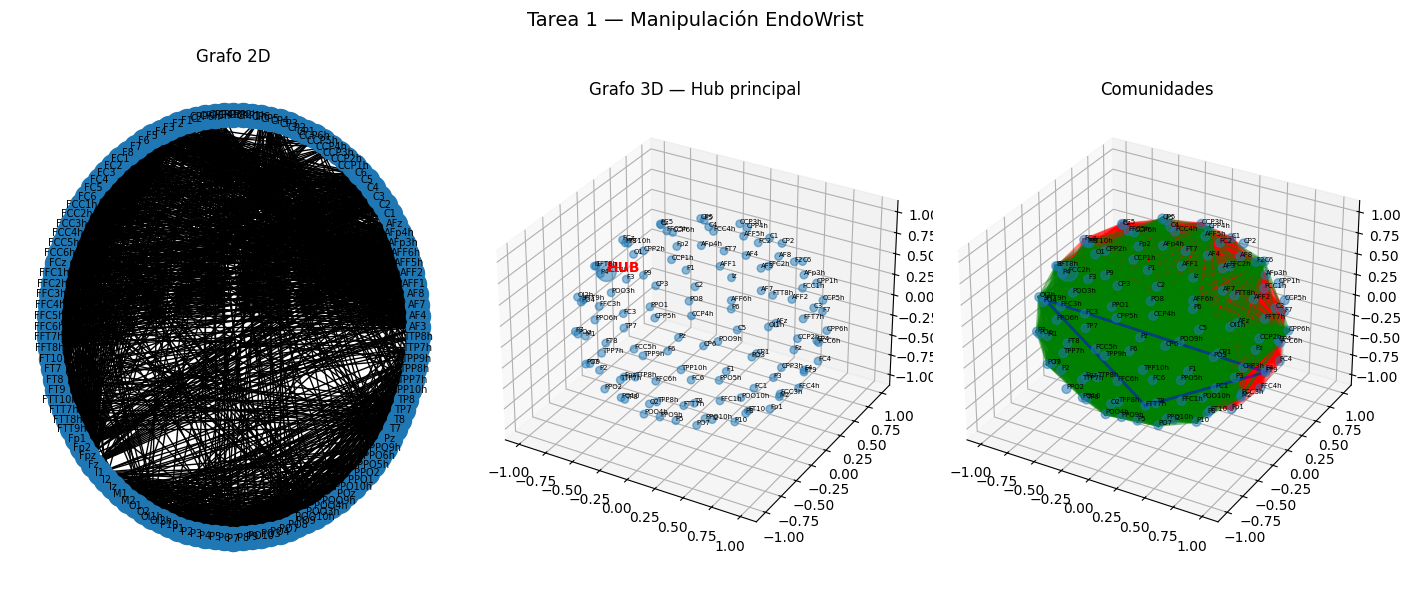

In [67]:
fig = plt.figure(figsize=(14, 6))

fig.suptitle("Tarea 1 — Manipulación EndoWrist", fontsize=14)

# grafo 2d
ax1 = fig.add_subplot(1, 3, 1)
grafo2D(capsula_t3, ax1)
ax1.set_title("Grafo 2D")

# grafo 3d
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
grafo3D(coords3, hub_principal3, ax2)
ax2.set_title("Grafo 3D — Hub principal")

# grafo comunidades
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
grafo_comunidades(comunidades3, hub_principal3, coords3, ax3)

plt.tight_layout()
plt.show()

# Tarea 4 - Control y manejo de la aguja

In [60]:
lista4 = lista_dfs(plv_dict["15"])
for i in range(len(lista4)):
    np.fill_diagonal(lista4[i].values, np.nan)
    
lista_recor4, comunes = recortar_a_comunes(lista4)
lista_recortada4 = [limpiar_nombres_canales(df.copy()) for df in lista_recor4]

In [61]:
capsula_t4 = capsula(lista_recortada4, 0.3, 0.6)
capsula_t4 = limpiar_nombres_canales(capsula_t4)
capsula_t4

AF3  AF4  AF7  AF8  AFF1  AFF2  AFF5h  AFF6h  AFp3h  AFp4h  ...  T7  \
AF3      0    1    1    1     1     1      1      1      1      1  ...   0   
AF4      1    0    1    1     1     1      1      1      1      1  ...   0   
AF7      1    1    0    1     1     1      1      0      1      1  ...   0   
AF8      1    1    1    0     0     1      0      1      1      1  ...   0   
AFF1     1    1    1    0     0     1      1      1      1      1  ...   0   
...    ...  ...  ...  ...   ...   ...    ...    ...    ...    ...  ...  ..   
TPP7h    0    0    0    0     0     0      0      0      0      0  ...   1   
TPP8h    0    0    0    0     0     0      0      0      0      0  ...   0   
TPP9h    0    0    0    0     0     0      0      0      0      0  ...   1   
TTP7h    0    0    0    0     0     0      0      0      0      0  ...   1   
TTP8h    0    0    0    0     0     0      0      0      0      0  ...   0   

       T8  TP7  TP8  TPP10h  TPP7h  TPP8h  TPP9h  TTP7h  TTP8h  
AF3     0    0    0       0      0      0      0      0      0  
AF4     0    0    0       0      0      0      0      0      0  
AF7     0    0    0       0      0      0      0      0      0  
AF8     0    0    0       0      0      0      0      0      0  
AFF1    0    0    0       0      0      0      0      0      0  
...    ..  ...  ...     ...    ...    ...    ...    ...    ...  
TPP7h   0    1    1       1      0      0      1      1      0  
TPP8h   1    0    1       1      0      0      1      0      1  
TPP9h   0    1    1       1      1      1      0      1      0  
TTP7h   0    1    0       0      1      0      1      0      0  
TTP8h   1    0    1       1      0      1      0      0      0  

[124 rows x 124 columns]

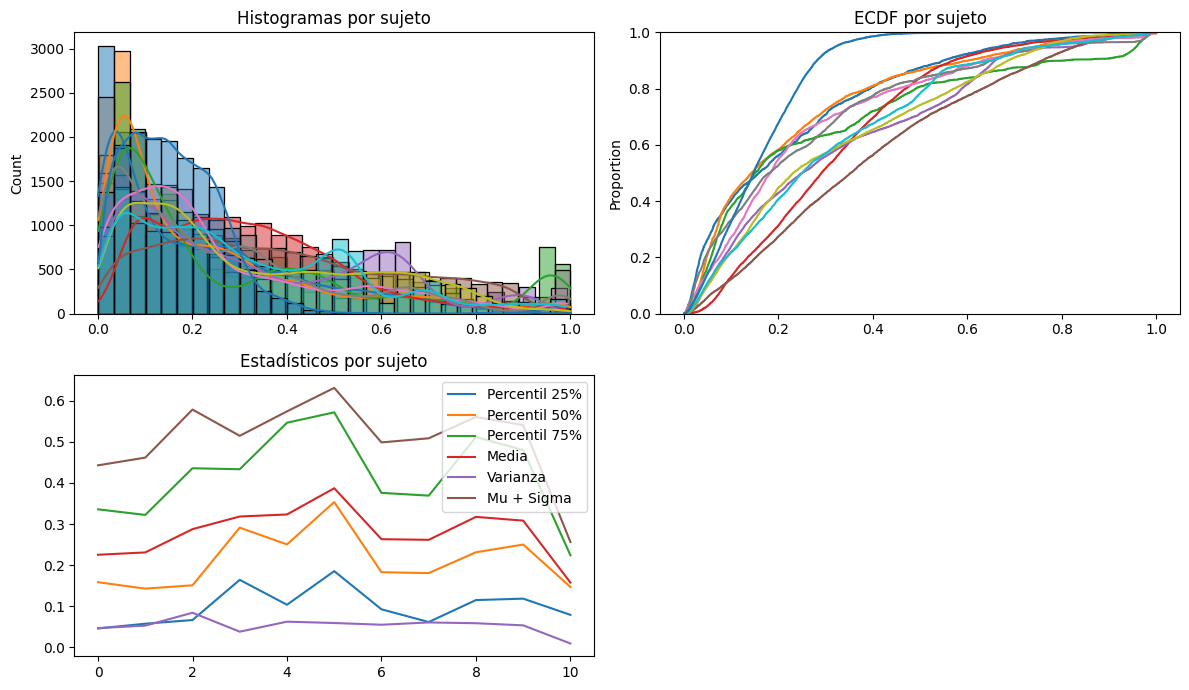

th25      th50      th75  promedio  mu_sigma
min       0.04622  0.143049  0.223964  0.157648  0.256223
max      0.185558   0.35339  0.571374  0.386955   0.63087
mediana  0.092751  0.182898  0.433144  0.287554  0.514314
MAD      0.026035  0.039849  0.078134  0.030729  0.052917

In [66]:
tarea4 = lista_dfs((plv_dict["15"]))

tabla4 = analisis_estadisticos(tarea4)
tabla4

Text(0.5, 0.98, 'Análisis para valor de umbral al 60% de la población en la tarea 3')

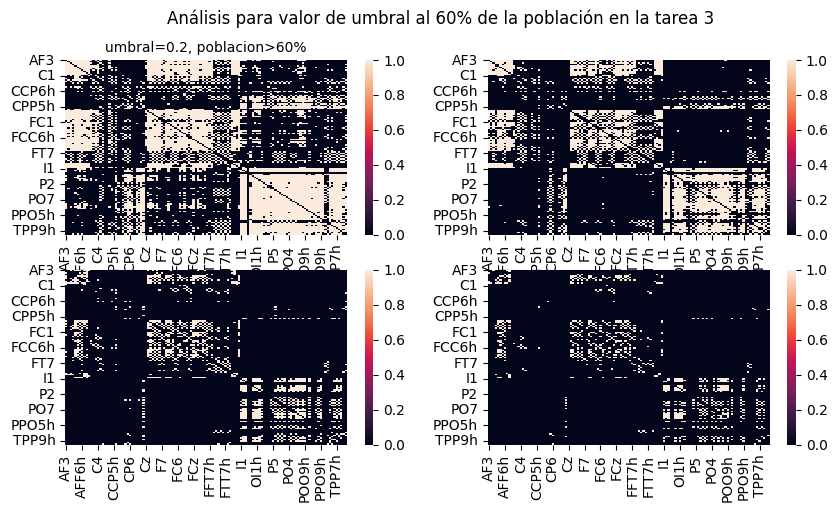

In [67]:
# Análisis para valor de umbral al 60% de la población en la tarea 3
tarea4u1 = capsula(lista_recortada4, 0.2, 0.6)
tarea4u2 = capsula(lista_recortada4, 0.3, 0.6)
tarea4u3 = capsula(lista_recortada4, 0.5, 0.6)
tarea4u4 = capsula(lista_recortada4, 0.6, 0.6)

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

sns.heatmap(tarea4u1, ax=axes[0, 0])
sns.heatmap(tarea4u2, ax=axes[0, 1])
sns.heatmap(tarea4u3, ax=axes[1, 0])
sns.heatmap(tarea4u4, ax=axes[1, 1])

# plt.title('Mapas de calor para comparativa de umbrales')
axes[0, 0].set_title('umbral=0.2, poblacion>60%', fontsize=10)
fig.suptitle('Análisis para valor de umbral al 60% de la población en la tarea 3')

In [74]:
G4 = nx.from_pandas_adjacency(capsula_t4)
result4 = metricas_grafo_resumido(G4)
hub_principal4 = result4["top5_hubs"][0]
comunidades4 = community.greedy_modularity_communities(G4)

In [68]:
coords4 = generar_coords_esfera_para_canales(capsula_t4.index)
coords4

x         y         z
AF3    0.000000  1.000000  0.000000
AF4   -0.132431  0.983740  0.121318
AF7    0.022114  0.967480 -0.251980
AF8    0.187712  0.951220  0.244838
AFF1  -0.349332  0.934959 -0.061792
...         ...       ...       ...
TPP7h -0.340012 -0.934959  0.101207
TPP8h  0.158582 -0.951220 -0.264638
TPP9h  0.050692 -0.967480  0.247817
TTP7h -0.145396 -0.983740 -0.105432
TTP8h  0.000000 -1.000000 -0.000000

[124 rows x 3 columns]

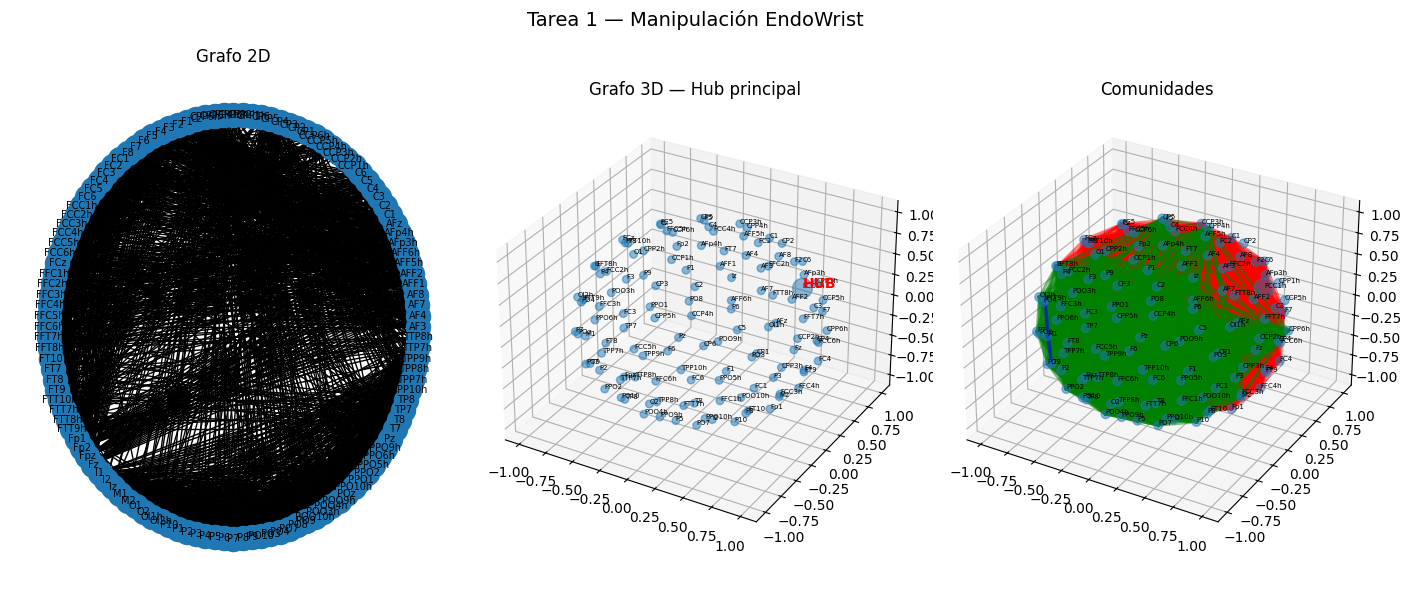

In [75]:
fig = plt.figure(figsize=(14, 6))

fig.suptitle("Tarea 1 — Manipulación EndoWrist", fontsize=14)

# grafo 2d
ax1 = fig.add_subplot(1, 3, 1)
grafo2D(capsula_t4, ax1)
ax1.set_title("Grafo 2D")

# grafo 3d
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
grafo3D(coords4, hub_principal4, ax2)
ax2.set_title("Grafo 3D — Hub principal")

# grafo comunidades
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
grafo_comunidades(comunidades4, hub_principal4, coords4, ax3)

plt.tight_layout()
plt.show()

# Tarea 5 Manejo de la aguja

In [ ]:
lista5 = lista_dfs(plv_dict["17"])
for i in range(len(lista5)):
    np.fill_diagonal(lista5[i].values, np.nan)
    
lista_recor5, comunes = recortar_a_comunes(lista5)
lista_recortada5 = [limpiar_nombres_canales(df.copy()) for df in lista_recor6]

In [ ]:
capsula_t5 = capsula(lista_recortada5, 0.3, 0.6)
capsula_t5 = limpiar_nombres_canales(capsula_t5)
capsula_t5

In [ ]:
tarea5 = lista_dfs((plv_dict["17"]))

tabla5 = analisis_estadisticos(tarea5)
tabla5

In [ ]:
# Análisis para valor de umbral al 60% de la población en la tarea 3
tarea5u1 = capsula(lista_recortada6, 0.2, 0.6)
tarea5u2 = capsula(lista_recortada6, 0.3, 0.6)
tarea5u3 = capsula(lista_recortada6, 0.5, 0.6)
tarea5u4 = capsula(lista_recortada6, 0.6, 0.6)

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

sns.heatmap(tarea5u1, ax=axes[0, 0])
sns.heatmap(tarea5u2, ax=axes[0, 1])
sns.heatmap(tarea5u3, ax=axes[1, 0])
sns.heatmap(tarea5u4, ax=axes[1, 1])

# plt.title('Mapas de calor para comparativa de umbrales')
axes[0, 0].set_title('umbral=0.2, poblacion>60%', fontsize=10)
fig.suptitle('Análisis para valor de umbral al 60% de la población en la tarea 3')

In [ ]:
G5 = nx.from_pandas_adjacency(capsula_t5)
result5 = metricas_grafo_resumido(G5)
hub_principal5 = result5["top5_hubs"][0]
comunidades5 = community.greedy_modularity_communities(G5)

In [ ]:
coords5 = generar_coords_esfera_para_canales(capsula_t5.index)
coords5

In [ ]:
fig = plt.figure(figsize=(14, 6))

fig.suptitle("Tarea 1 — Manipulación EndoWrist", fontsize=14)

# grafo 2d
ax1 = fig.add_subplot(1, 3, 1)
grafo2D(capsula_t5, ax1)
ax1.set_title("Grafo 2D")

# grafo 3d
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
grafo3D(coords5, hub_principal5, ax2)
ax2.set_title("Grafo 3D — Hub principal")

# grafo comunidades
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
grafo_comunidades(comunidades5, hub_principal5, coords5, ax3)

plt.tight_layout()
plt.show()

# Tarea 6 - Energía y disección

In [76]:
lista6 = lista_dfs(plv_dict["23"])
for i in range(len(lista6)):
    np.fill_diagonal(lista6[i].values, np.nan)
    
lista_recor6, comunes = recortar_a_comunes(lista6)
lista_recortada6 = [limpiar_nombres_canales(df.copy()) for df in lista_recor6]

In [77]:
capsula_t6 = capsula(lista_recortada6, 0.3, 0.6)
capsula_t6 = limpiar_nombres_canales(capsula_t6)
capsula_t6

AF3  AF4  AF7  AF8  AFF1  AFF2  AFF5h  AFF6h  AFp3h  AFp4h  ...  T7  \
AF3      0    1    1    1     1     1      1      1      1      1  ...   0   
AF4      1    0    1    1     1     1      1      1      1      1  ...   0   
AF7      1    1    0    1     1     1      1      1      1      1  ...   0   
AF8      1    1    1    0     1     1      0      1      1      0  ...   0   
AFF1     1    1    1    1     0     1      1      1      1      1  ...   0   
...    ...  ...  ...  ...   ...   ...    ...    ...    ...    ...  ...  ..   
TPP7h    0    0    0    0     0     0      0      0      0      0  ...   1   
TPP8h    0    0    0    0     0     0      0      0      0      0  ...   0   
TPP9h    0    0    0    0     0     0      0      0      0      0  ...   1   
TTP7h    0    0    0    0     0     0      0      0      0      0  ...   1   
TTP8h    0    0    0    0     0     0      0      0      0      0  ...   0   

       T8  TP7  TP8  TPP10h  TPP7h  TPP8h  TPP9h  TTP7h  TTP8h  
AF3     0    0    0       0      0      0      0      0      0  
AF4     0    0    0       0      0      0      0      0      0  
AF7     0    0    0       0      0      0      0      0      0  
AF8     0    0    0       0      0      0      0      0      0  
AFF1    0    0    0       0      0      0      0      0      0  
...    ..  ...  ...     ...    ...    ...    ...    ...    ...  
TPP7h   0    1    0       1      0      1      1      1      0  
TPP8h   1    0    1       1      1      0      1      0      1  
TPP9h   0    1    1       1      1      1      0      1      0  
TTP7h   0    1    0       0      1      0      1      0      0  
TTP8h   1    0    1       0      0      1      0      0      0  

[124 rows x 124 columns]

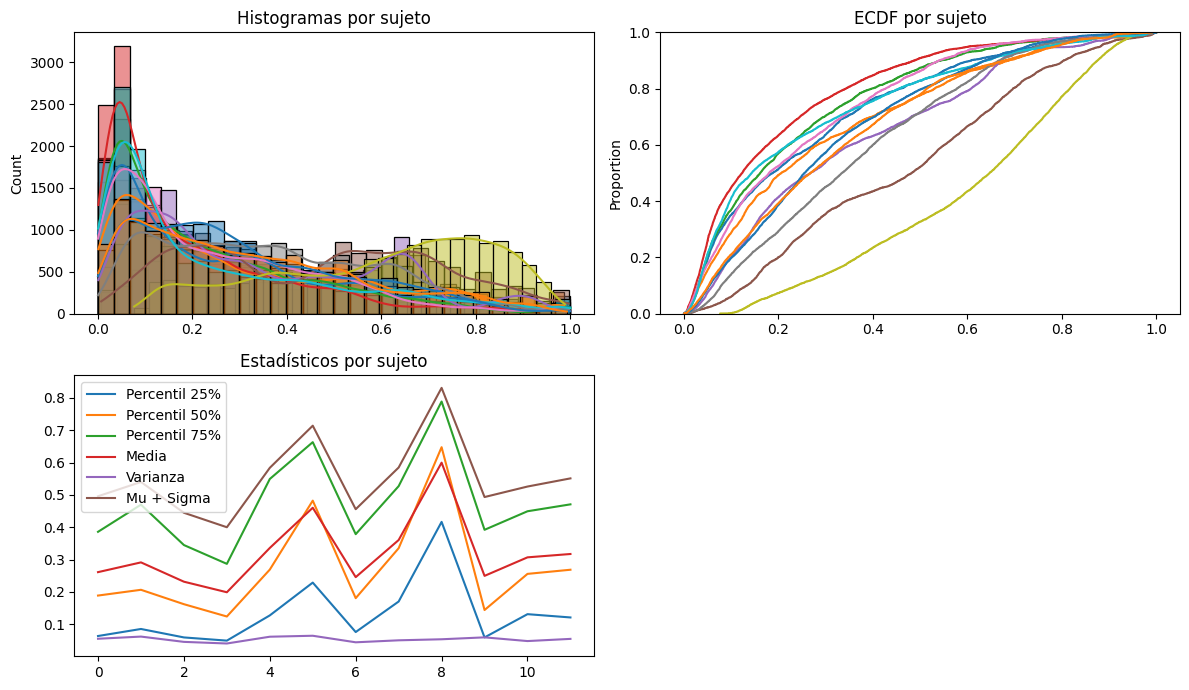

th25      th50      th75  promedio  mu_sigma
min       0.04933  0.123921  0.286735  0.198901  0.399982
max      0.416564  0.647515  0.788705  0.599704   0.83102
mediana  0.103161  0.231131  0.459593  0.299078  0.532875
MAD      0.041773  0.059813  0.077404   0.05145  0.051341

In [78]:
tarea6 = lista_dfs((plv_dict["23"]))

tabla6 = analisis_estadisticos(tarea6)
tabla6

Text(0.5, 0.98, 'Análisis para valor de umbral al 60% de la población en la tarea 3')

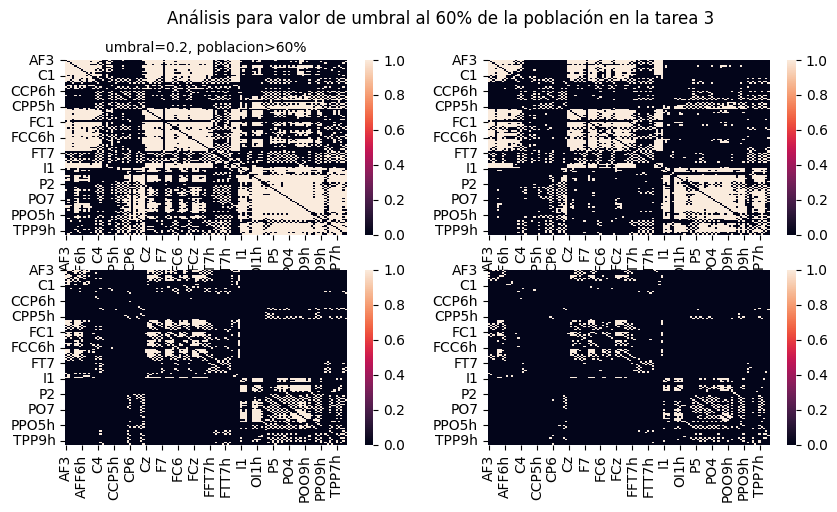

In [79]:
# Análisis para valor de umbral al 60% de la población en la tarea 3
tarea6u1 = capsula(lista_recortada6, 0.2, 0.6)
tarea6u2 = capsula(lista_recortada6, 0.3, 0.6)
tarea6u3 = capsula(lista_recortada6, 0.5, 0.6)
tarea6u4 = capsula(lista_recortada6, 0.6, 0.6)

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

sns.heatmap(tarea6u1, ax=axes[0, 0])
sns.heatmap(tarea6u2, ax=axes[0, 1])
sns.heatmap(tarea6u3, ax=axes[1, 0])
sns.heatmap(tarea6u4, ax=axes[1, 1])

# plt.title('Mapas de calor para comparativa de umbrales')
axes[0, 0].set_title('umbral=0.2, poblacion>60%', fontsize=10)
fig.suptitle('Análisis para valor de umbral al 60% de la población en la tarea 3')

In [80]:
G6 = nx.from_pandas_adjacency(capsula_t6)
result6 = metricas_grafo_resumido(G6)
hub_principal6 = result6["top5_hubs"][0]
comunidades6 = community.greedy_modularity_communities(G6)

In [81]:
coords6 = generar_coords_esfera_para_canales(capsula_t6.index)
coords6

x         y         z
AF3    0.000000  1.000000  0.000000
AF4   -0.132431  0.983740  0.121318
AF7    0.022114  0.967480 -0.251980
AF8    0.187712  0.951220  0.244838
AFF1  -0.349332  0.934959 -0.061792
...         ...       ...       ...
TPP7h -0.340012 -0.934959  0.101207
TPP8h  0.158582 -0.951220 -0.264638
TPP9h  0.050692 -0.967480  0.247817
TTP7h -0.145396 -0.983740 -0.105432
TTP8h  0.000000 -1.000000 -0.000000

[124 rows x 3 columns]

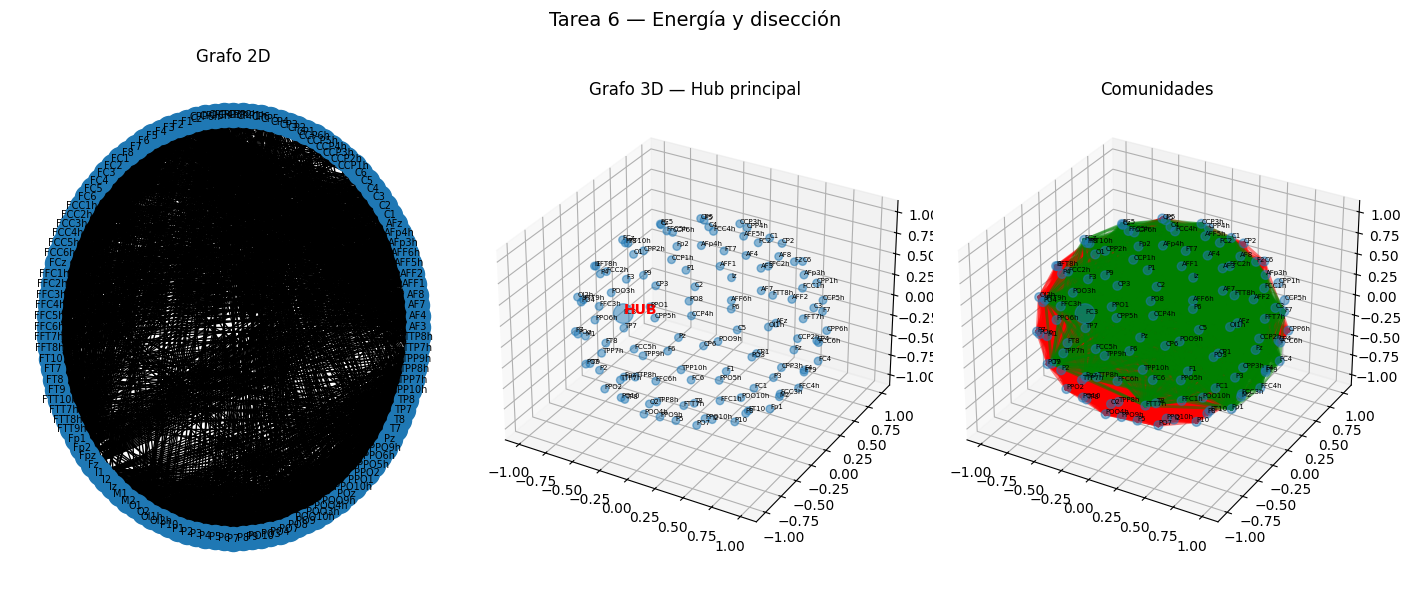

In [82]:
fig = plt.figure(figsize=(14, 6))

fig.suptitle("Tarea 6 — Energía y disección", fontsize=14)

# grafo 2d
ax1 = fig.add_subplot(1, 3, 1)
grafo2D(capsula_t6, ax1)
ax1.set_title("Grafo 2D")

# grafo 3d
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
grafo3D(coords6, hub_principal6, ax2)
ax2.set_title("Grafo 3D — Hub principal")

# grafo comunidades
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
grafo_comunidades(comunidades6, hub_principal6, coords6, ax3)

plt.tight_layout()
plt.show()